In [2]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

## Import Dataset

In [3]:
RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
    "../../Josh/transcription_pipeline-main/test_data/2024-05-09/Halo552-RBSPWM_embryo01/"
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01"
]

test_dataset_name = RBSVar2_datasets[1]

### Import from Scratch

#### Import MS2 Dataset

In [ ]:
## Import from scratch
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    # import_previous=True, 
)
dataset.save();

#### Import FullEmbryo Dataset

In [4]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    #import_previous=True
)
FullEmbryo_dataset.save()

### Load from Zarr

#### Load MS2 Dataset

In [5]:
## Load from zarr
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    # working_storage_mode='zarr',
    import_previous=True, 
)

#### Load FullEmbryo Dataset

In [ ]:
# FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
#     name_folder=test_dataset_name,
#     import_previous=True
# )
# Not working currently, but reported to Yovan where it only reads in the last channel


## Starting a DASK Client for parallel processing

In [ ]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

In [ ]:
client.restart()

In [ ]:
client

## Nuclear Tracking

In [ ]:
nuclear_tracking = nuclear_pipeline.Nuclear(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    search_range_um=1.5,
    stitch=False,
    stitch_max_distance=4,
    stitch_max_frame_distance=2,
    client=client,
    keep_futures=False,
)

nuclear_tracking.track_nuclei(
        working_memory_mode="zarr",
        working_memory_folder=test_dataset_name,
        trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
    )
    # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
    # tracking information.
nuclear_tracking.save_results(
        name_folder=test_dataset_name, save_array_as=None
    )

In [ ]:
# Load nuclear tracking results
nuclear_tracking = nuclear_pipeline.Nuclear()
nuclear_tracking.read_results(name_folder=test_dataset_name)

## Spot Tracking

In [ ]:
%%time

spot_tracking = spot_pipeline.Spot(
    data=dataset.channels_full_dataset[1],
    global_metadata=dataset.export_global_metadata[1],
    frame_metadata=dataset.export_frame_metadata[1],
    labels=None,#nuclear_tracking.reordered_labels,
    expand_distance=3,
    search_range_um=4.2,
    retrack_search_range_um=4.5,
    threshold_factor=1.3,
    memory=3,
    retrack_after_filter=False,
    stitch=True,
    min_track_length=0,
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    keep_bandpass=False,
    keep_futures=False,
    keep_spot_labels=False,
    evaluate=True,
    retrack_by_intensity=True,
    client=client,
)

spot_tracking.extract_spot_traces(
    working_memory_folder=test_dataset_name, 
    stitch=True,
    retrack_after_filter=True,
    trackpy_log_path = test_dataset_name+'/trackpy_log'
)

# Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# quantification information.
spot_tracking.save_results(name_folder=test_dataset_name, save_array_as='None')

## Make Compiled Dataframe

In [6]:
# Load spot tracking results
track_spots = spot_pipeline.Spot()
track_spots.read_results(name_folder=test_dataset_name)

# Load spot tracking dataframe
spot_df = track_spots.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167..."


## Full Embryo Analysis

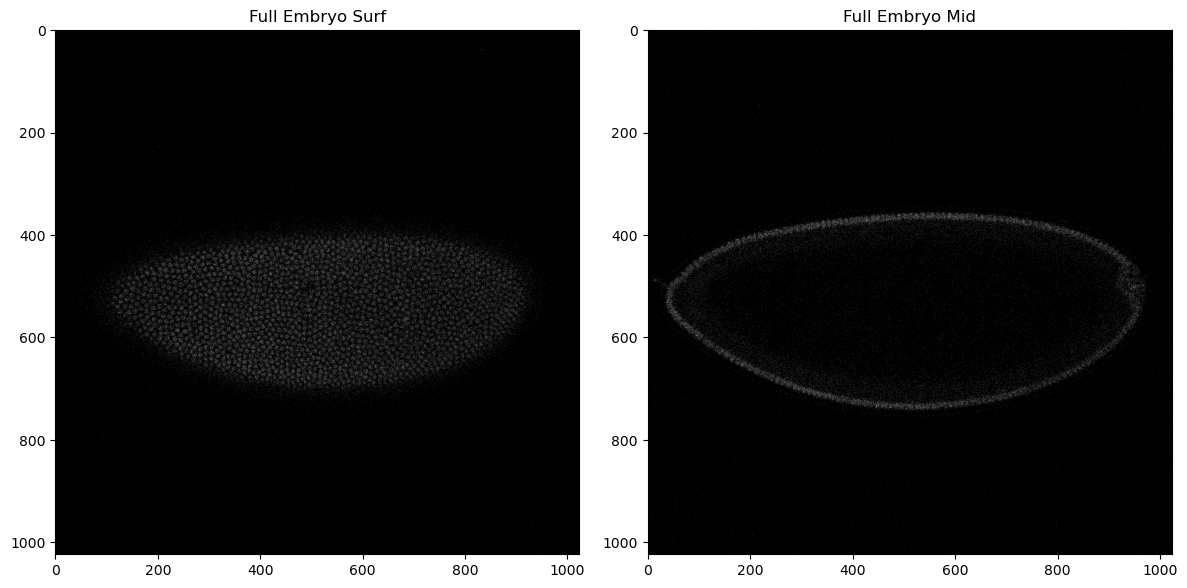

In [6]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()
plt.close()

In [14]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=0)

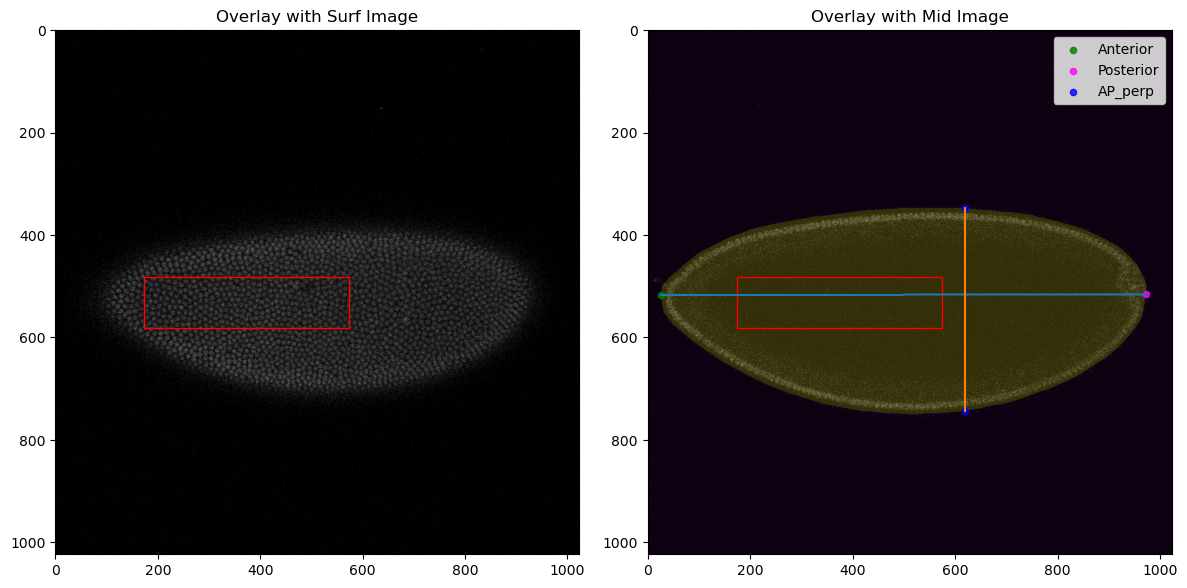

In [15]:
fullEmbryo.find_ap_axis(make_plots=True)

In [16]:
compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5...","[0.3313042994154892, 0.33061939863823764, 0.33...","[0.12989276429317786, 0.13046486912365637, 0.1..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12...","[0.20607289824970965, 0.20656023392145914, 0.2...","[-0.07141580498769587, -0.07138726677781301, -..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503...","[0.39849964210332955, 0.3976967603478775, 0.39...","[-0.04077345373697253, -0.0406101626655149, -0..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06...","[0.25763308598055856, 0.25708181719549955, 0.2...","[0.029244134641654648, 0.029403017599059004, 0..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167...","[0.35117942468222907, 0.3504678742505178, 0.35...","[0.037814288423547136, 0.038802411760013165, 0..."


# Plot Traces

In [7]:
# Restrict to longer traces
min_frames = 40
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
plt.close()

In [8]:
plt.close()

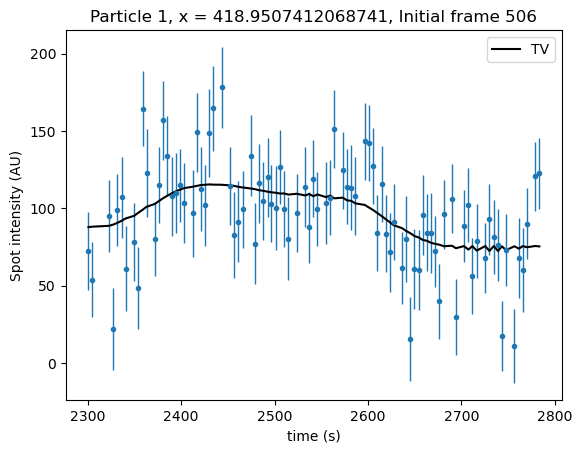

In [10]:
# %matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt


from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
#median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]


# plt.close()
# plt.plot(traces[curr_pos][0], traces[curr_pos][1], label="Original")otts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

## Define Fit Functions

In [17]:
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

# Version with normalization and regularization
def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[0]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]


def fit_half_cycle(MS2, timepoints, t_interp, std_errors, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    
    # Parameter bounds
    lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Scaling factors to normalize parameters
    scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])

    # Scaled bounds
    lb_scaled = np.array(lb) / scale_factors
    ub_scaled = np.array(ub) / scale_factors
    x0_scaled = np.array(x0) / scale_factors

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Negative log-likelihood function
    def negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp) / std_errors
        regularization = reg * np.sum(params[:]**2)
        nll = 0.5 * np.sum(residuals**2) + regularization
        return nll

    # Initial parameter estimation using least_squares
    res = least_squares(negative_log_likelihood, 
                        x0_scaled, bounds=(lb_scaled, ub_scaled), 
                        args=(MS2, timepoints, t_interp, std_errors), max_nfev=max_nfev)
    

    # Define log-probability function for MCMC
    def log_prob(params, MS2, timepoints, t_interp, std_errors, scale_factors, lb_scaled, ub_scaled):
        if np.any(params < lb_scaled) or np.any(params > ub_scaled):
            return -np.inf
        nll = negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors)
        return -nll  # Convert to log-probability

    # MCMC parameters
    nwalkers = 10
    ndim = len(x0_scaled)
    nsteps = 1000
    initial_pos = res.x + 1e-4 * np.random.randn(nwalkers, ndim)
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(MS2, timepoints,
                                                                    t_interp, std_errors,
                                                                    scale_factors, lb_scaled, ub_scaled))
    # Run MCMC until the acceptance fraction is at least 0.5
    sampler.run_mcmc(initial_pos, nsteps, 
                     progress=False, tune=True)

    # Flatten the chain and discard burn-in steps
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Extract and rescale fit parameters
    basal, t_on, t_dwell, rate = np.median(flat_samples, axis=0) * scale_factors

    # Calculate confidence intervals
    CI = np.percentile(flat_samples, [5, 95], axis=0).T * scale_factors[:, np.newaxis]

    return basal, t_on, t_dwell, rate, CI

def first_derivative(x, y):
    """
    Compute the first discrete derivative of y with respect to x.
    Parameters:
    x (numpy.ndarray): Independent variable data points.
    y (numpy.ndarray): Dependent variable data points.
    Returns:
    numpy.ndarray: Discrete first derivative of y with respect to x.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    dydx = dy / dx

    # Use central differences for the interior points and forward/backward differences for the endpoints
    dydx_central = np.zeros_like(y)
    dydx_central[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dydx_central[0] = dydx[0]
    dydx_central[-1] = dydx[-1]

    return dydx_central

def mean_sign_intervals(function):
    """
    Compute the mean of function over intervals where the function has a constant sign.
    Parameters:
    derivative (numpy.ndarray): Array representing the function.
    Returns:
    numpy.ndarray: Array with mean values of the function over intervals with constant sign.
    """
    # Identify where the sign changes
    sign_changes = np.diff(np.sign(function))
    # Get indices where the sign changes
    change_indices = np.where(sign_changes != 0)[0] + 1

    # Initialize the list to hold mean values
    mean_values = []
    start_index = 0

    for end_index in change_indices:
        # Calculate the mean of the current interval
        interval_mean = np.mean(function[start_index:end_index])
        # Append the mean value to the list
        mean_values.extend([interval_mean] * (end_index - start_index))
        # Update the start index
        start_index = end_index

    # Handle the last interval
    interval_mean = np.mean(function[start_index:])
    mean_values.extend([interval_mean] * (len(function) - start_index))

    return np.array(mean_values), change_indices

# Function to generate fits for all traces
def fit_all_traces(traces, tv_denoised_traces):
    """
    Fit half-cycles to all traces in the dataset.
    Parameters:
    traces (list): List of traces to fit.
    tv_denoised_traces (list): List of TV denoised traces.
    Returns:
    list: List of tuples with fit parameters for each trace.
    """
    # Initialize the list to hold fit results
    fit_results = []

    # Create new dataframe to store fit results
    dataframe = pd.DataFrame(columns=['particle', 'fit_results'])
    
    for i in range(len(traces)):
        # Compute the first derivative of TV denoised with respect to time
        dy_dx = first_derivative(traces[i][0], tv_denoised_traces[i])

        # Compute the mean of the first derivative over intervals with constant sign
        mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

        # Keep datapoints from before first sign change
        try:
            timepoints = traces[i][0][:change_indices[0]]
            MS2 = traces[i][1][:change_indices[0]]
            MS2_std = traces[i][2][:change_indices[0]]

            # Interpolate the timepoints
            t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
        except:
            print(f"Failed to find derivative sign change for trace {traces[i][3]}")
            fit_results.append([None, None, None, None, None])
            dataframe.loc[i] = [traces[i][3], [None, None, None, None, None]]
            continue


        # Compute the fit values
        try:
            basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)
            fit_result = [timepoints, t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                                [basal, t_on, t_dwell, rate, CI]]
            
            fit_results.append(fit_result)
            dataframe.loc[i] = [traces[i][3], fit_result]
        except:
            print(f"Failed to fit trace {traces[i][3]}")
            fit_results.append([timepoints,t_interp, MS2, None, None])
            dataframe.loc[i] = [traces[i][3], [timepoints,t_interp, MS2, None, None]]
            continue

    return fit_results, dataframe

## Perform Fitting on Ordered Spots

In [18]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

# Restrict to longer traces
min_frames = 40
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
# Restrict to traces starting at frame nc14_frame and above
nc14_frame = 438
traces_compiled_dataframe = traces_compiled_dataframe[
    traces_compiled_dataframe["frame"].apply(lambda x: x[0] >= nc14_frame)
]

# Order the traces based on the mean x position
traces_compiled_dataframe = traces_compiled_dataframe.sort_values(
    by="ap", key=lambda x: x.apply(np.mean)
)

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)


# Generate TV denoised traces
tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]

# Generate fits for all traces
fit_results, dataframe = fit_all_traces(traces, tv_denoised_traces)

print(f"Number of traces: {len(traces)}")

# Show number of traces with valid fits
print(f"Number of traces with valid fits: {sum([result[4] is not None for result in fit_results])}")

# Show number of traces with invalid fits
print(f"Number of traces with invalid fits: {sum([result[4] is None for result in fit_results])}")

traces_compiled_dataframe_fits = pd.merge(traces_compiled_dataframe, dataframe, on='particle', how='inner')

# Add columns: the approval status, denoised trace, and fitted rate of the particle
length = traces_compiled_dataframe_fits.index.max()
status = [1 for _ in range(length+1)]
traces_compiled_dataframe_fits['tv_denoised_trace'] = tv_denoised_traces
traces_compiled_dataframe_fits['approval_status'] = status

traces_compiled_dataframe_fits.head()

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Failed to find derivative sign change for trace 301


/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encoun

Failed to fit trace 225
Failed to fit trace 61


/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encoun

Failed to fit trace 183


/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Failed to fit trace 130


/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Number of traces: 137
Number of traces with valid fits: 132
Number of traces with invalid fits: 5


,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90,fit_results,tv_denoised_trace,approval_status
0,258,"[477, 478, 480, 481, 482, 483, 484, 487, 488, ...","[2171.107000350952, 2175.7789993286133, 2184.6...","[128.7251724137931, 135.9469775280899, 140.735...","[24.313749617281225, 27.69677638823855, 26.526...","[4.603282016220054, 4.942160779400182, 4.67300...","[127.07031562237795, 127.83368252652197, 126.0...","[0.15729420887677814, 0.15743431449090262, 0.1...","[0.037118404274094255, 0.037872351078835215, 0...","[[2171.107000350952, 2175.7789993286133, 2184....","[166.17713895477272, 166.3681431518292, 166.75...",1
1,175,"[481, 483, 485, 486, 487, 488, 489, 491, 492, ...","[2189.798999786377, 2198.718999862671, 2207.22...","[61.20902890173411, 69.0975608108108, 58.19808...","[21.98403302021128, 22.67749098437827, 27.6577...","[10.156944029488237, 11.327991746313508, 11.02...","[209.99416029420047, 211.55650260195583, 210.4...","[0.1595903079881736, 0.16007446449888316, 0.15...","[0.11901895221212938, 0.12056201490511394, 0.1...","[[2189.798999786377, 2198.718999862671, 2207.2...","[110.3288781619955, 110.80643754627314, 111.79...",1
2,276,"[485, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2207.8589992523193, 2216.566999435425, 2221.2...","[67.97339306358381, 75.30527624309391, 87.8247...","[23.011813316636232, 24.525760823825948, 27.04...","[12.268911710174077, 11.675486979035856, 11.41...","[58.323222547333174, 57.757125096299006, 58.96...","[0.16046347727779428, 0.16021813249545222, 0.1...","[-0.030780336001107352, -0.03133944769701967, ...","[[2207.8589992523193, 2216.566999435425, 2221....","[108.82564520239234, 109.10907207684687, 109.6...",1
3,313,"[466, 467, 468, 469, 470, 471, 472, 473, 474, ...","[2118.413999557495, 2123.2940006256104, 2127.5...","[85.72741875000001, 49.311, 112.05398136645962...","[25.59952213087846, 28.315972153539068, 25.320...","[5.123111904292513, 5.031120722834717, 7.02653...","[22.26367942794014, 22.20860118785958, 22.2815...","[0.15750912669878972, 0.15747109397920817, 0.1...","[-0.06639489718747522, -0.06644929575112024, -...","[[2118.413999557495, 2123.2940006256104, 2127....","[110.80487559634494, 111.30480424823801, 112.3...",1
4,108,"[461, 463, 464, 465, 466, 467, 468, 469, 470, ...","[2095.673999786377, 2104.183000564575, 2108.64...","[66.07425, 78.0525621301775, 55.76315, 73.5683...","[24.982523501057464, 23.666196080514528, 24.98...","[6.622973244232735, 8.61024155058676, 9.265356...","[142.98810338320803, 142.3111077702882, 142.61...","[0.15812922750464098, 0.15895084124012263, 0.1...","[0.05283976336848658, 0.05217112201605997, 0.0...","[[2095.673999786377, 2104.183000564575, 2108.6...","[85.6171155974248, 85.96931952744035, 85.97253...",1


## Plot and Inspect Fits

In [22]:
from warnings import warn
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
%matplotlib widget

### Josh's Fit checking function
def check_particle_fit(binned_particles_fitted):
    '''
    Check the fit of each particle. All particles are approved by default.
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    # import matplotlib
    # plt.close('all')
    # matplotlib.use('Qt5Agg')
    def update_plot(particle_index):
        ax.clear()
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                fit_result = particle_data['fit_results'].values[0]
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
                ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)})', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            # bin = particle_data['bin'].values[0]
            mean_ap = (particle_data.loc[particle_data["particle"] == particle, "ap"]
            .values[0]
            .mean()
            )
            initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
            values[0][0]
            )
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
                
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), AP = {np.round(mean_ap, 2)}, Initial frame {initial_frame}')
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        if event.key == 'left':
            particle_index = max(0, particle_index - 1)
        elif event.key == 'right':
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0
        elif event.key == 'p':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 2
        update_plot(particle_index)

    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

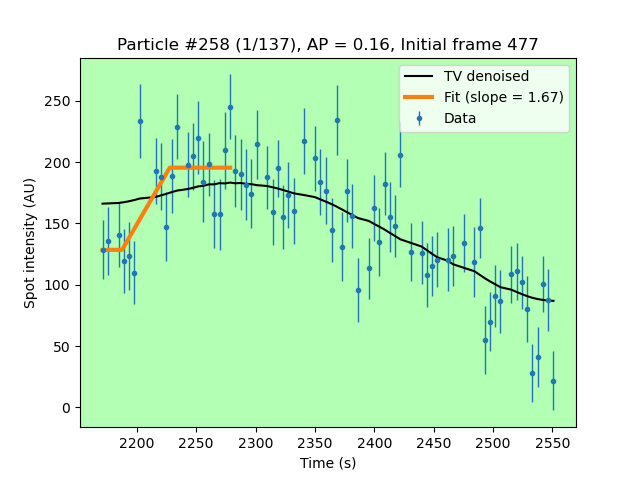

In [23]:
check_particle_fit(traces_compiled_dataframe_fits)

In [34]:
traces_compiled_dataframe_fits_checked = traces_compiled_dataframe_fits[traces_compiled_dataframe_fits['approval_status'] == 1].reset_index()

file_path = test_dataset_name +'/' + 'traces_compiled_dataframe_fits_checked.pkl'
print(file_path)
# traces_compiled_dataframe_fits_checked.to_pickle(file_path, compression=None)

test_data/2024-07-25/Halo673_RBSVar2_embryo01/traces_compiled_dataframe_fits_checked.pkl


bin_counts = [ 0.  0.  0.  0.  0.  0.  4. 12.  8. 12.  9.  6. 14.  9. 10.  4.  4.  2.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
np.sum(bin_counts) = 94.0


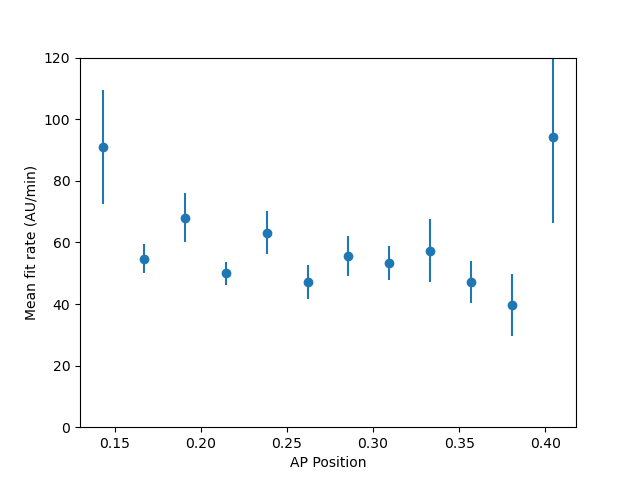

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'dataframe' with a column 'mean_x' representing the mean x position
# and a column 'rate' representing the fit rates

# Define the number of bins and the bin width
num_bins = 42
bin_width = 1/num_bins

# Create an array to store the bin indices for each trace
bin_indices = np.zeros(len(traces_compiled_dataframe_fits_checked))

# Loop through traces_compiled_dataframe_fits_checked and assign each trace to a bin based on mean_ap position
for i in range(len(traces_compiled_dataframe_fits_checked)):
    particle = traces_compiled_dataframe_fits_checked['particle'][i]
    bin_indices[i] = (
        traces_compiled_dataframe_fits_checked.loc[traces_compiled_dataframe_fits_checked['particle'] == particle, 'ap']
        .values[0].mean() // bin_width
    )

# Calculate the number of traces in each bin
bin_counts = np.zeros(num_bins)
for i in range(num_bins):
    bin_counts[i] = np.sum(bin_indices == i)

print(f'bin_counts = {bin_counts}')
print(f'np.sum(bin_counts) = {np.sum(bin_counts)}')

# Calculate the average fit rates for each bin and store particle IDs with rates in each bin
mean_fit_rates = np.zeros(num_bins)
bin_particles_rates = np.zeros(num_bins, dtype=object)
SE_fit_rates = np.zeros(num_bins)
for i in range(num_bins):
    if bin_counts[i] == 0:
        mean_fit_rates[i] = np.nan
        continue
    else:
        rates = (
            60*traces_compiled_dataframe_fits_checked.loc[bin_indices == i, 'fit_results'].apply(
                lambda x: x[4][3] if x[4] is not None else np.nan).values
            )
        particles = (
            traces_compiled_dataframe_fits_checked.loc[bin_indices == i, 'particle']
            .values
            )
        
        # Store the particle IDs with their rates in each bin for further analysis
        bin_particles_rates[i] = {
            'bin': i,
            'particles': particles,
            'rates': rates
        }
        
        mean_fit_rates[i] = (np.nanmean(rates))

        # Standard error of the mean
        SE_fit_rates[i] = np.nanstd(rates) / np.sqrt(len(rates))


# Plot the mean slopes for each bin number
plt.figure()
#plt.errorbar(np.arange(num_bins), mean_fit_rates, yerr=SE_fit_rates, fmt='o')
#plt.xlabel('Bin number')
plt.errorbar(np.arange(num_bins)/num_bins, mean_fit_rates, yerr=SE_fit_rates, fmt='o')
plt.xlabel('AP Position')
plt.ylabel('Mean fit rate (AU/min)')
plt.ylim(0,120)
plt.show()

In [30]:
bin_particles_rates

array([0, 0, 0, 0, 0, 0,
       {'bin': 6, 'particles': array([175, 313, 108, 114]), 'rates': array([152.80037767,  85.47793373,  61.52984888,  64.07183685])},
       {'bin': 7, 'particles': array([123, 103,  13, 212, 256, 102,  15,  65, 131, 239, 307,  62]), 'rates': array([62.38230773, 33.81320345, 72.13665165, 62.14159143, 74.97018979,
              41.7542874 , 79.48309309, 69.32730072, 38.86072522, 35.38681464,
              38.60232444, 47.8012367 ])}                                                                                                                                           ,
       {'bin': 8, 'particles': array([ 10,  14, 246, 143, 135,   2,  96,  19]), 'rates': array([59.47780053, 80.31060304, 63.40285658, 16.57617313, 84.57684874,
              85.91023766, 61.13078388, 92.8503253 ])}                                                                                                          ,
       {'bin': 9, 'particles': array([173, 235,  89, 151,  18,  48, 211, 23